In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima
from sklearn.metrics import r2_score
import joblib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')

In [4]:
root = '/content/drive/MyDrive/Bitcoin/'
train_df = pd.read_csv(f"{root}preprocessed/btc_train.csv", index_col="Open time", parse_dates=True)
test_df  = pd.read_csv(f"{root}preprocessed/btc_test.csv", index_col="Open time", parse_dates=True)
print(train_df.shape, test_df.shape)

(2280, 28) (570, 28)


In [5]:
train_series = train_df["log_return_norm"]
test_series  = test_df["log_return_norm"]

print("Train length:", len(train_series))
print("Test length:", len(test_series))

Train length: 2280
Test length: 570


In [6]:
auto_model = auto_arima(train_series,
                        start_p=0, max_p=10,
                        start_q=0, max_q=10,
                        d=0, max_d=2,
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
p, d, q = auto_model.order
print("Best ARIMA order:", (p, d, q))

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8002.113, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8001.120, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8001.330, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7999.779, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=7999.069, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8000.731, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=7996.504, Time=1.77 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7995.716, Time=1.69 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7994.390, Time=1.58 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=7995.748, Time=0.95 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8000.252, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=7998.121, Time=0.89 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7996.687, Time=1.63 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 9.535 seconds
Best ARIMA order: (1, 

In [7]:
tscv = TimeSeriesSplit(n_splits=5)
arima_preds_train = np.full(len(train_series), np.nan)

print("\nGenerating ARIMA OOS predictions with TimeSeriesSplit...\n")

for fold, (tr_idx, val_idx) in enumerate(tscv.split(train_series)):
    print(f"Fold {fold+1}: Train {tr_idx[0]}:{tr_idx[-1]},  Val {val_idx[0]}:{val_idx[-1]}")

    train_fold = train_series.iloc[tr_idx]
    val_fold   = train_series.iloc[val_idx]

    # Fit ARIMA on training fold
    model = ARIMA(train_fold, order=(p, d, q)).fit()

    # Forecast the length of the validation fold
    preds = model.forecast(steps=len(val_fold))

    # Store OOS preds
    arima_preds_train[val_idx] = preds.values

# Convert to pandas Series with same index
arima_preds_train = pd.Series(arima_preds_train, index=train_series.index)


Generating ARIMA OOS predictions with TimeSeriesSplit...

Fold 1: Train 0:379,  Val 380:759
Fold 2: Train 0:759,  Val 760:1139
Fold 3: Train 0:1139,  Val 1140:1519
Fold 4: Train 0:1519,  Val 1520:1899
Fold 5: Train 0:1899,  Val 1900:2279


In [8]:
final_arima = ARIMA(train_series, order=(p, d, q)).fit()
print(final_arima.summary())

# Forecast on the test set
forecast = final_arima.forecast(steps=len(test_series))
forecast.index = test_series.index

                               SARIMAX Results                                
Dep. Variable:        log_return_norm   No. Observations:                 2280
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3993.624
Date:                Sat, 29 Nov 2025   AIC                           7995.248
Time:                        05:07:59   BIC                           8018.176
Sample:                    02-01-2018   HQIC                          8003.611
                         - 04-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0446      0.037      1.197      0.231      -0.028       0.118
ar.L1          0.8863      0.094      9.453      0.000       0.703       1.070
ma.L1         -0.8548      0.105     -8.147      0.0

In [9]:
# Directional Accuracy
direction_acc = np.mean(np.sign(test_series.values) == np.sign(forecast.values)) * 100

# Correlation
correlation = np.corrcoef(test_series.values, forecast.values)[0, 1]

# R^2
r2 = r2_score(test_series.values, forecast.values)

# Sharpe Ratio
strategy_returns = np.sign(forecast.values) * test_series.values
sharpe_ratio = strategy_returns.mean() / (strategy_returns.std() + 1e-8)

print(f"Directional Accuracy: {direction_acc:.2f}%")      # no better than random guesssing
print(f"Correlation:          {correlation:.4f}")         # no meaningful predictive relationship
print(f"R²:                   {r2:.4f}")                  # model explains -% of return variance
print(f"Sharpe Ratio:         {sharpe_ratio:.4f}")        # strategy earns almost no reward, not tradeable

Directional Accuracy: 50.00%
Correlation:          0.0396
R²:                   -0.0003
Sharpe Ratio:         0.0168


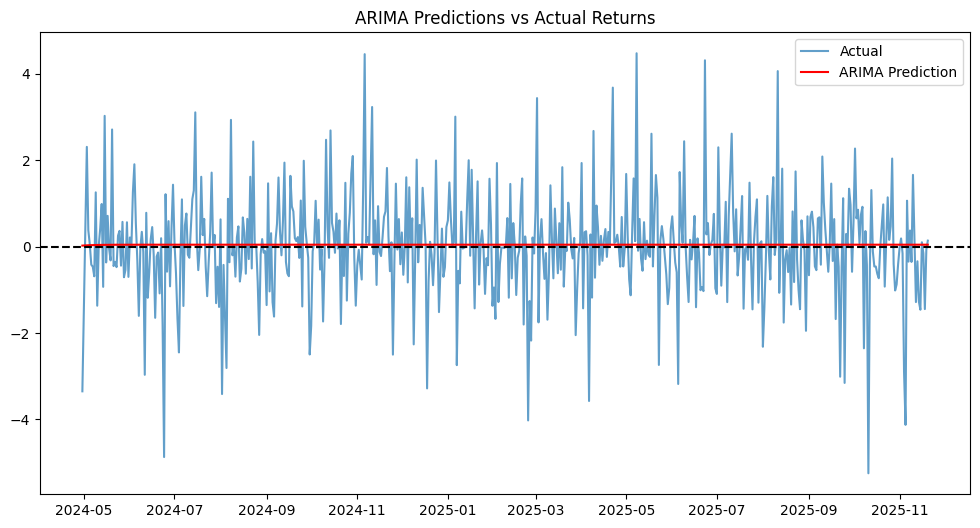

In [10]:
plt.figure(figsize=(12,6))
plt.plot(test_series.index, test_series, label="Actual", alpha=0.7)
plt.plot(test_series.index, forecast, label="ARIMA Prediction", color="red")
plt.axhline(0, color="black", linestyle="--")
plt.title("ARIMA Predictions vs Actual Returns")
plt.legend()
plt.show()

In [11]:
np.save(f"{root}predictions/arima_train_preds.npy", arima_preds_train)
np.save(f"{root}predictions/arima_test_preds.npy", forecast)
print("Saved ARIMA predictions.")

Saved ARIMA predictions.


In [12]:
joblib.dump(final_arima, f"{root}models/arima_model.pkl")
print("Saved ARIMA model.")

Saved ARIMA model.
